Extraccion
Este ataque consiste en "copiar" un modelo
Necesitamos acceso al modelo para consultar predicciones, y parte de la data de entrenamiento

In [1]:
import tensorflow as tf
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from art.estimators.classification import KerasClassifier #No soporta TF 2
from art.attacks.evasion import FastGradientMethod
from art.utils import load_dataset

# Disabling eager execution from TF 2
tf.compat.v1.disable_eager_execution()

C:\Users\Quezada\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Quezada\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\art\estimators\certification\__init__.py:14: UserWarning: PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality
  warnings.warn("PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality")


In [2]:
#Se utilizara una version del dataset del MNIST con 60k digitos a mano que incluye ART
(train_images, train_labels), (test_images, test_labels), min, max = load_dataset(name="mnist")

In [3]:
#Usamos las 10k observaciones que no fueron utilizadas en el modelo 
train_images_stolen = train_images[50000:]
train_labels_stolen = train_labels[50000:]

In [5]:
#Cargamos el modelo

vulnerable_model = tf.keras.models.load_model("modelovictima1")

In [6]:
clasificador = KerasClassifier(
    model=vulnerable_model,
    clip_values=(min, max))

In [7]:
from art.attacks.extraction import CopycatCNN
# Creating the "neural net thief" object
# that will steal the original classifier
copycat_cnn = CopycatCNN(
    batch_size_fit=256,
    batch_size_query=256,
    nb_epochs=20,
    nb_stolen=20000,
    classifier=clasificador
    )

In [8]:
#Definimos un nuevo modelo
def create_blank_model():
    # Defining the model
    model = tf.keras.models.Sequential([
        Conv2D(filters=32, kernel_size=2, activation="relu", input_shape=(28, 28, 1)),
        MaxPool2D(pool_size=2),
        Conv2D(filters=128, kernel_size=3, activation="relu"),
        MaxPool2D(pool_size=2),
        Conv2D(filters=32, kernel_size=2, activation="relu"),
        MaxPool2D(pool_size=2),
        Flatten(),        
        Dense(units=10, activation="softplus")
    ])

    # Compiling the model
    model.compile(
        optimizer="SGD",
        loss="categorical_crossentropy",
        metrics=["accuracy"]
        )

    # Returning the model
    return model

In [9]:
model_stolen = KerasClassifier(
    model=create_blank_model(), 
    clip_values=(min, max)
    )

In [10]:
# Extracting a thieved classifier
# by training the reference model
stolen_classifier = copycat_cnn.extract(
    x=train_images_stolen, 
    y=train_labels_stolen, 
    thieved_classifier=model_stolen
    )

C:\Users\Quezada\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Train on 10000 samples
Epoch 1/20
10000/10000 [==============================] - 5s 513us/sample - loss: 2.2924 - accuracy: 0.1356
Epoch 2/20
10000/10000 [==============================] - 5s 451us/sample - loss: 2.2789 - accuracy: 0.1983
Epoch 3/20
10000/10000 [==============================] - 5s 452us/sample - loss: 2.2646 - accuracy: 0.2377
Epoch 4/20
10000/10000 [==============================] - 5s 456us/sample - loss: 2.2493 - accuracy: 0.3151
Epoch 5/20
10000/10000 [==============================] - 5s 471us/sample - loss: 2.2314 - accuracy: 0.3672
Epoch 6/20
10000/10000 [==============================] - 5s 493us/sample - loss: 2.2095 - accuracy: 0.4291
Epoch 7/20
10000/10000 [==============================] - 5s 476us/sample - loss: 2.1821 - accuracy: 0.4934
Epoch 8/20
10000/10000 [==============================] - 4s 448us/sample - loss: 2.1473 - accuracy: 0.5299
Epoch 9/20
10000/10000 [==============================] - 5s 468us/sample - loss: 2.1027 - accuracy: 0.5670
Epoch

In [11]:
# Testing the performance of the original classifier
score_original = clasificador._model.evaluate(
    x=test_images, 
    y=test_labels
    )

# Testing the performance of the stolen classifier
score_stolen = stolen_classifier._model.evaluate(
    x=test_images, 
    y=test_labels
    )

# Comparing test losses
print(f"Original test loss: {score_original[0]:.2f} " 
      f"vs stolen test loss: {score_stolen[0]:.2f}")

# Comparing test accuracies
print(f"Original test accuracy: {score_original[1]:.2f} " 
      f"vs stolen test accuracy: {score_stolen[1]:.2f}")

C:\Users\Quezada\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Original test loss: 0.04 vs stolen test loss: 0.73
Original test accuracy: 0.99 vs stolen test accuracy: 0.74


Inferencia
Ataque MIA, se busca inferir la data utilizada para entrenamiento

In [12]:
from art.attacks.inference.model_inversion import MIFace

# Defining a model inversion attack
attack = MIFace(
    classifier=clasificador,
    max_iter=500, #Este parametro depende del hardware, es el numero de repeticiones para el gradiente descendente
    batch_size=256)

In [13]:
# Defining the target labels for model inversion
y = np.arange(start=0, stop=10)

# Inspecting the target labels
print(y)

[0 1 2 3 4 5 6 7 8 9]


In [14]:
# Defining an initialization array for model inversion
#La calidad del output depende tambien de este vector de inicializaion
x_init_average = np.zeros(shape=(10, 28, 28, 1)) + np.mean(a=test_images, axis=0)

In [15]:
# Running model inversion
x_infer_from_average = attack.infer(
    x=x_init_average, 
    y=y
    )

Model inversion: 100%|██████████| 1/1 [00:45<00:00, 45.88s/it]


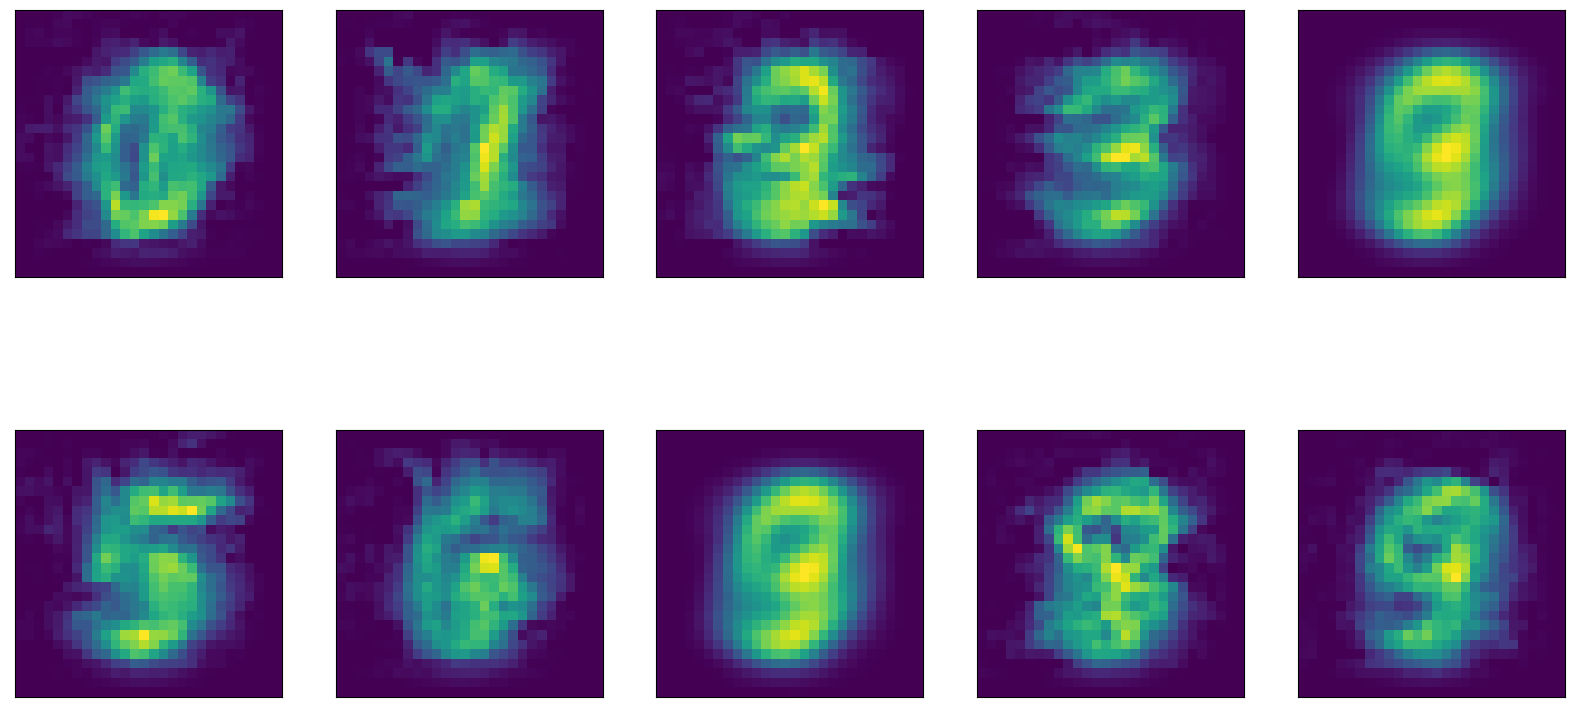

In [16]:
nrows, ncols = 2, 5
# Creating a figure and axes for our plot
fig, axes = plt.subplots(
    nrows=nrows, 
    ncols=ncols, 
    figsize=(20, 10)
    )

# Declaring a counting variable
counter = 0

# Iterating over the axes and plotting the inferred images in them
for i in range(nrows):
    for j in range(ncols):        
        axes[i, j].set_xticks(ticks=[])
        axes[i, j].set_yticks(ticks=[])
        axes[i, j].imshow(X=x_infer_from_average[counter])

        # Incrementing the counter
        counter += 1

# Showing the plotted axes
plt.show()